In [75]:
%pylab inline
import os, urllib
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
from tensorflow.keras.models import model_from_json
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [76]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [11]:
traindf = pd.read_csv('train.csv')
traindf['code'] = traindf['type'].astype('category').cat.codes
traindf.head()

In [77]:
def createModel():
    vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (224, 224, 3))

    for layer in vgg_model.layers[:-5]:
        layer.trainable=False
        
    input = Input(shape=(224, 224, 3), name = 'image_input')
    output_vgg16_conv = vgg_model(input)

    x = BatchNormalization()(output_vgg16_conv)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.2)(x)

    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(13, activation='softmax')(x)

    model = Model(inputs=input, outputs=x)

    model.summary()

    model.compile(loss = "categorical_crossentropy",
              optimizer = optimizers.Adadelta(lr = 1.0, rho = 0.95, epsilon = 1e-08, decay = 0.0),
              metrics = ['accuracy'])
    
    return model

In [78]:
def printHistory(history, epochs):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle("VGG-19", fontsize=12)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_list = list(range(1,epochs+1))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_xticks(np.arange(0, epochs+1, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    ax2.set_xticks(np.arange(0, epochs+1, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

In [80]:
def trainModelDF(images, epochs, cross_validation_folds):
    print("Train Model")
     
    datagen_train = ImageDataGenerator(rescale=1./255.,
                                       rotation_range=10,
                                       width_shift_range=0.1, 
                                       height_shift_range=0.1)

    datagen_valid = ImageDataGenerator(rescale=1./255)
            
    print("Cross validation")
    kfold = StratifiedKFold(n_splits=cross_validation_folds, shuffle=True)
    cvscores = []
    iteration = 1
    
    t = images.code
    
    for train_index, test_index in kfold.split(np.zeros(len(t)), t):

        print("======================================")
        print("Iteration = ", iteration)

        iteration = iteration + 1

        train = images.loc[train_index]
        test = images.loc[test_index]

        print("======================================")

        model = createModel()
        
        train_generator = datagen_train.flow_from_dataframe(dataframe=train,
                                                  directory="/content/drive/My Drive/DataMining/google",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));

        valid_generator=datagen_valid.flow_from_dataframe(dataframe=test,
                                                  directory="/content/drive/My Drive/DataMining/google",
                                                  x_col="chart",
                                                  y_col="type",
                                                  batch_size=32,
                                                  seed=42,
                                                  shuffle=False,
                                                  class_mode="categorical",
                                                  target_size=(224, 224));
        
        STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
        STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

        #Trains the model on data generated batch-by-batch by a Python generator
        history = model.fit_generator(generator=train_generator,\
                            validation_data = valid_generator, \
                            steps_per_epoch=STEP_SIZE_TRAIN, \
                            validation_steps=STEP_SIZE_VALID, \
                            epochs=epochs, \
                            verbose=1)
                
        scores = model.evaluate_generator(generator=valid_generator, steps=STEP_SIZE_VALID)
        print("Accuarcy %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        cvscores.append(scores[1] * 100)
        
        printHistory(history, epochs)

    accuracy = np.mean(cvscores);
    std = np.std(cvscores);
    print("Accuracy: %.2f%% (+/- %.2f%%)" % (accuracy, std))
    return accuracy, std

Train Model
Cross validation
Iteration =  1
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
batch_normalization_20 (Batc (None, 7, 7, 512)         2048      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 4, 4, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_20 (Dense

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 569 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2887 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 146 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 718 validated image filenames belonging to 13 classes.
Epoch 1/20


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


90/90 [==============================] - 54s 600ms/step - loss: 1.7521 - accuracy: 0.4988 - val_loss: 4.9483 - val_accuracy: 0.3196
Epoch 2/20
90/90 [==============================] - 54s 598ms/step - loss: 1.0194 - accuracy: 0.6914 - val_loss: 6.2260 - val_accuracy: 0.3438
Epoch 3/20
90/90 [==============================] - 54s 597ms/step - loss: 0.9196 - accuracy: 0.7222 - val_loss: 1.4499 - val_accuracy: 0.6804
Epoch 4/20
90/90 [==============================] - 54s 597ms/step - loss: 0.8342 - accuracy: 0.7499 - val_loss: 1.5991 - val_accuracy: 0.7074
Epoch 5/20
90/90 [==============================] - 54s 597ms/step - loss: 0.6751 - accuracy: 0.7898 - val_loss: 1.3934 - val_accuracy: 0.7344
Epoch 6/20
90/90 [==============================] - 54s 601ms/step - loss: 0.6169 - accuracy: 0.8182 - val_loss: 1.9445 - val_accuracy: 0.6307
Epoch 7/20
90/90 [==============================] - 54s 599ms/step - loss: 0.5474 - accuracy: 0.8333 - val_loss: 0.7307 - val_accuracy: 0.8168
Epoch 8/20

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 567 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2889 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 148 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 716 validated image filenames belonging to 13 classes.
Epoch 1/20
90/90 [==============================] - 55s 609ms/step - loss: 1.7875 - accuracy: 0.4792 - val_loss: 1.7182 - val_accuracy: 0.5483
Epoch 2/20
90/90 [==============================] - 54s 597ms/step - loss: 1.0660 - accuracy: 0.6825 - val_loss: 1.6137 - val_accuracy: 0.6165
Epoch 3/20
90/90 [==============================] - 54s 598ms/step - loss: 0.9471 - accuracy: 0.7035 - val_loss: 1.5667 - val_accuracy: 0.6719
Epoch 4/20
90/90 [==============================] - 54s 596ms/step - loss: 0.7905 - accuracy: 0.7525 - val_loss: 2.6806 - val_accuracy: 0.5881
Epoch 5/20
90/90 [==============================] - 54s 596ms/step - loss: 0.7623 - accuracy: 0.7627 - val_loss: 1.0366 - val_accuracy: 0.7784
Epoch 6/20
90/90 [==============================] - 53s 593ms/step - loss: 0.6936 - accuracy: 0.7900 - val_loss: 1.0548 - val_accuracy: 0.7898
Epoch 7/20
90/90 [==============================] - 53s 591ms/step - loss: 0.5996

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 570 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2886 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 145 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 719 validated image filenames belonging to 13 classes.
Epoch 1/20
90/90 [==============================] - 54s 603ms/step - loss: 1.8388 - accuracy: 0.4646 - val_loss: 3.6356 - val_accuracy: 0.2926
Epoch 2/20
90/90 [==============================] - 53s 589ms/step - loss: 1.2511 - accuracy: 0.6296 - val_loss: 4.2779 - val_accuracy: 0.4034
Epoch 3/20
90/90 [==============================] - 53s 590ms/step - loss: 0.9306 - accuracy: 0.7186 - val_loss: 1.9577 - val_accuracy: 0.6264
Epoch 4/20
90/90 [==============================] - 53s 590ms/step - loss: 0.8375 - accuracy: 0.7498 - val_loss: 2.0109 - val_accuracy: 0.6406
Epoch 5/20
90/90 [==============================] - 53s 594ms/step - loss: 0.7666 - accuracy: 0.7589 - val_loss: 1.5600 - val_accuracy: 0.7216
Epoch 6/20
90/90 [==============================] - 53s 590ms/step - loss: 0.6705 - accuracy: 0.7936 - val_loss: 1.8541 - val_accuracy: 0.6804
Epoch 7/20
90/90 [==============================] - 53s 589ms/step - loss: 0.6129

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 584 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2872 validated image filenames belonging to 13 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 131 invalid image filename(s) in x_col="chart". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 733 validated image filenames belonging to 13 classes.
Epoch 1/20
89/89 [==============================] - 55s 618ms/step - loss: 1.9013 - accuracy: 0.4412 - val_loss: 20.8237 - val_accuracy: 0.0497
Epoch 2/20
89/89 [==============================] - 55s 618ms/step - loss: 1.1065 - accuracy: 0.6581 - val_loss: 2.4846 - val_accuracy: 0.3991
Epoch 3/20
89/89 [==============================] - 54s 612ms/step - loss: 0.9703 - accuracy: 0.7130 - val_loss: 1.5670 - val_accuracy: 0.7315
Epoch 4/20
89/89 [==============================] - 54s 609ms/step - loss: 0.8049 - accuracy: 0.7504 - val_loss: 0.9956 - val_accuracy: 0.7315
Epoch 5/20
89/89 [==============================] - 55s 617ms/step - loss: 0.7255 - accuracy: 0.7761 - val_loss: 1.0766 - val_accuracy: 0.7344
Epoch 6/20
89/89 [==============================] - 54s 606ms/step - loss: 0.6328 - accuracy: 0.8021 - val_loss: 1.2890 - val_accuracy: 0.7273
Epoch 7/20
89/89 [==============================] - 54s 605ms/step - loss: 0.556

(84.00568127632141, 1.6701049284018508)

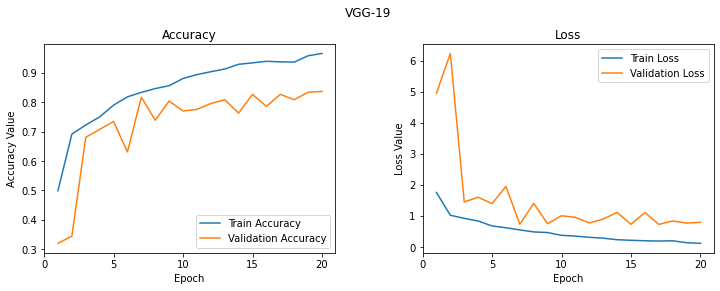

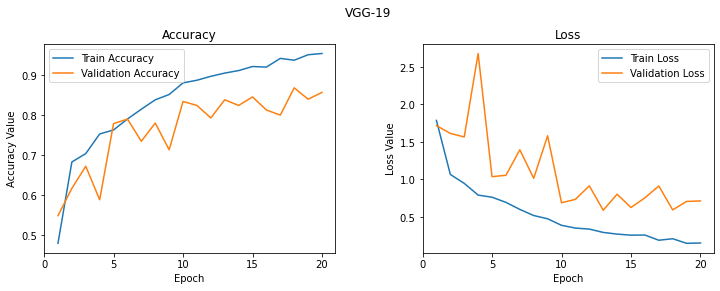

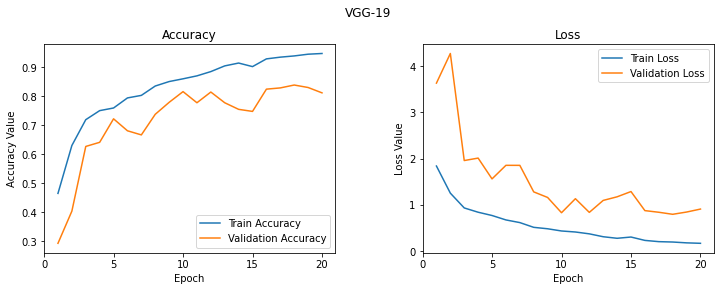

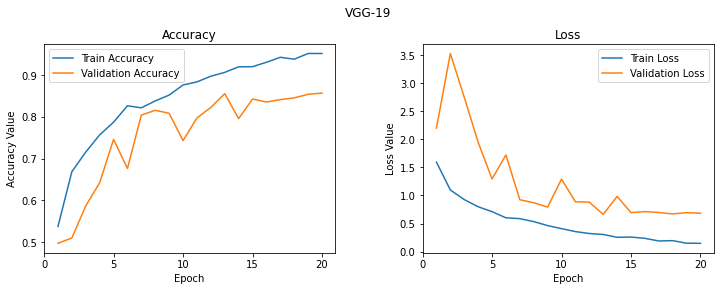

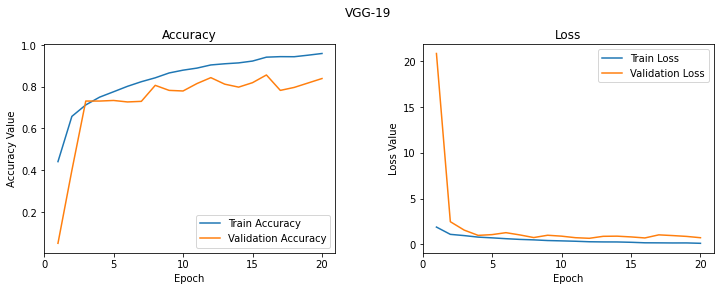

In [81]:
trainModelDF(traindf, cross_validation_folds = 5, epochs = 20)

In [82]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
testdf = pd.read_csv('test.csv')

test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = "./../DataMining/AllData/filtered/images/",
    x_col = "chart",
    y_col = None,
    batch_size = 1,
    seed = 42,
    shuffle = False,
    class_mode = None,
    target_size = (224, 224))

In [ ]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [ ]:
test_generator.reset()
STEP_SIZE_TEST=test_generator.n // test_generator.batch_size

pred = loaded_model.predict(test_generator,
                            steps=STEP_SIZE_TEST,
                            verbose=1)

In [ ]:
predicted_class_indices = np.argmax(pred, axis=1)

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames = test_generator.filenames

results = pd.DataFrame({"chart": filenames, "type": predictions})
results.to_csv("predictions.csv", index = False)

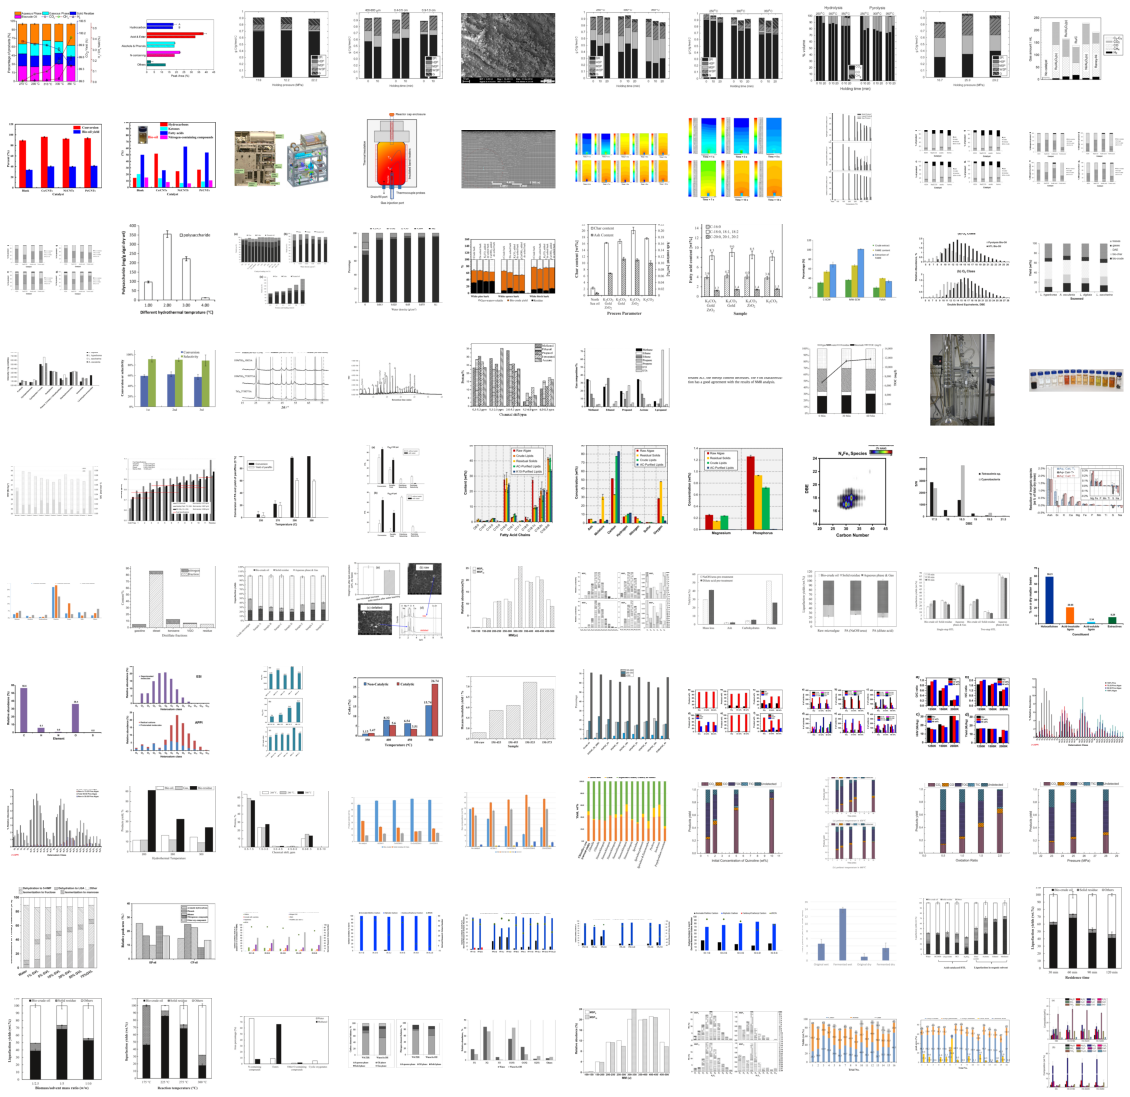

In [6]:
barplots = results.loc[results['type'] == 'BarGraph']

f, ax = plt.subplots(10, 10, figsize = (20, 20))

for index in range(100):
    ax[index // 10, index % 10].imshow(mpimg.imread("./../DataMining/AllData/filtered/images/" + barplots.iloc[index]['chart']))
    ax[index // 10, index % 10].axis('off')
    ax[index // 10, index % 10].set_aspect('equal')
    
plt.show()